<a href="https://colab.research.google.com/github/Khanjan24/BERT-Text-Classification/blob/main/Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###1.Import packages and data


To create Neural Network models, import tensorflow and keras in addition to pandas and numpy.

In [ ]:
import matplotlib.pyplot as plt
import tensorflow
import keras
from keras import metrics
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd

Also import 'drugTweets.txt' file that contains user_id, tweets, and classification label.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  


Saving drugTweets.txt to drugTweets (2).txt
User uploaded file "drugTweets.txt" with length 368650 bytes


In [ ]:
drugTweets = pd.read_csv('drugTweets.txt', delimiter = "\t", header = 0)

###2.Tokenization & Split Train / Test

In [ ]:
from keras.preprocessing.text import Tokenizer

To train the Neural Network model, we tokenize the tweets. We will use the Tokenizer module that cuts tweets by each space and returns a list of words and removes punctuation. We only keep 5000 most frequent words in our vocabulary and can set the number by num_words parameter. Tokenize tweets by fit_on_texts function. This function maps words to the index of a token in a dictionary.

In [ ]:
num_words = 5000

tokenizer = Tokenizer(num_words = num_words)
tokenizer.fit_on_texts(drugTweets.text_text)


And then, split the dataset to training and testing set by 80/20. Tokenizer module has 'texts_to_sequences' function that creates an index sequence of the sentences. Convert train/test text to index sequences.

In [ ]:
test = drugTweets.sample(frac = 0.2, random_state = 123)
train = drugTweets.drop(test.index)

y_train = train.abuse
y_test = test.abuse

x_test_tokens = tokenizer.texts_to_sequences(test.text_text)
x_train_tokens = tokenizer.texts_to_sequences(train.text_text)

###3.Text Padding

In [ ]:
from keras.preprocessing.sequence import pad_sequences

All samples must have the same number of dimensions to use Keras. So we should put paddings on short tweets or cut the longer ones. To figure out the appropriate length, calculate the mean length of tweets and 2 standard deviations. We set this number as the length of sampels. 

In [ ]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens


26

Let's see how many tweets are less than 26 words. About 95.5% of tweets are shorter than 26 words.

In [ ]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9559164733178654

We can put paddings on sequences by pad_sequences function. Prior to this, we can decide a position to put padding either 'pre' or 'post' of the sentence.

In [ ]:
pad = 'post'

x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)



###4.RNN 

Recurrent Neural Network(RNN) - RNN accepts a concept that you can deliver trained data back to pre-layers by using LSTM(Long Short-Term Memory), so model can understand the sequence of the sentences.

For building a Nueral Networks, import necessary layers, optimizer and regularizers packages.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, GRU, LSTM, Dropout
from keras.regularizers import l1, l2

from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.utils import class_weight


In [ ]:
embedding_size = 64

Here, we build a RNN model. First, create a sequential object that we can stack layers. For RNN, we decide to pile Embedding - Dropout - LSTM - Dropout - Dense layers. Then compile the stack and use Adam as an optimizer. We put Dropout layers and regularizer as much as we can to avoid overfitting. 

In [ ]:
rnn = Sequential()

rnn.add(Embedding(input_dim = num_words,
                 output_dim = embedding_size,
                 input_length = max_tokens,
                 name = "embedding_layer"))

rnn.add(Dropout(0.5))

rnn.add(LSTM(units = 16,
            dropout = 0.4,
            kernel_regularizer=l1(0.0001),
            name = 'LSTM_layer'))

rnn.add(Dropout(0.5))
rnn.add(Dropout(0.1))

rnn.add(Dense(units = 1,
             activation = 'sigmoid',
             kernel_regularizer=l2(0.015),
             name = 'Ouput_Layer'))


optimizer = Adam(lr = 0.001, decay = 0.001)

rnn.compile(loss = 'binary_crossentropy',
           optimizer = optimizer,
           metrics = ['accuracy'])

Because the dataset is imbalanced, we will give different weights on labels. class_weight function calculates the weights automatically and we put this into fit function as a parameter.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5847868217054264, 1: 3.4485714285714284}

####Training

We decide to set batch_size as 64, and epochs as 4. Batch size the number of samples that will be propagated through the network and epoch is the number of times training data go through networks.

In [ ]:
rnn.fit(x_train_pad, y_train, batch_size = 64, validation_split = 0.02, epochs = 2, class_weight = class_weights)
preds_train = rnn.predict_classes(x_train_pad)
print(classification_report(y_train, preds_train, digits = 3))

Train on 2365 samples, validate on 49 samples
Epoch 1/2
2365/2365 [==============================] - 1s 476us/step - loss: 0.2087 - acc: 0.9780 - val_loss: 2.2996 - val_acc: 0.7959
Epoch 2/2
2365/2365 [==============================] - 1s 479us/step - loss: 0.1764 - acc: 0.9839 - val_loss: 2.6431 - val_acc: 0.7959
              precision    recall  f1-score   support

           0      0.992     0.994     0.993      2064
           1      0.962     0.951     0.957       350

    accuracy                          0.988      2414
   macro avg      0.977     0.973     0.975      2414
weighted avg      0.988     0.988     0.988      2414



#### Test

In [ ]:
preds = rnn.predict_classes(x_test_pad)
print(classification_report(y_test, preds, digits = 3))


              precision    recall  f1-score   support

           0      0.878     0.895     0.886       506
           1      0.391     0.351     0.370        97

    accuracy                          0.808       603
   macro avg      0.634     0.623     0.628       603
weighted avg      0.800     0.808     0.803       603



Check confusion_matrix of RNN model.

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, preds)

array([[453,  53],
       [ 63,  34]])

In the code below, return of fit() function stores accuracy/loss of training and validation as the change number of epochs. We can visualize it.

In [ ]:
rnn_mod_fit = rnn.fit(x_train_pad, y_train, batch_size=64,
          validation_split=0.05, epochs=20)

Train on 2293 samples, validate on 121 samples
Epoch 1/20
2293/2293 [==============================] - 2s 675us/step - loss: 0.1393 - acc: 0.9782 - val_loss: 0.4857 - val_acc: 0.8760
Epoch 2/20
2293/2293 [==============================] - 1s 636us/step - loss: 0.1220 - acc: 0.9839 - val_loss: 0.5270 - val_acc: 0.8512
Epoch 3/20
2293/2293 [==============================] - 1s 597us/step - loss: 0.1242 - acc: 0.9834 - val_loss: 0.5377 - val_acc: 0.8512
Epoch 4/20
2293/2293 [==============================] - 1s 636us/step - loss: 0.1165 - acc: 0.9847 - val_loss: 0.5520 - val_acc: 0.8512
Epoch 5/20
2293/2293 [==============================] - 1s 622us/step - loss: 0.1146 - acc: 0.9843 - val_loss: 0.5670 - val_acc: 0.8430
Epoch 6/20
2293/2293 [==============================] - 1s 593us/step - loss: 0.1115 - acc: 0.9891 - val_loss: 0.5924 - val_acc: 0.8347
Epoch 7/20
2293/2293 [==============================] - 1s 595us/step - loss: 0.1153 - acc: 0.9860 - val_loss: 0.6118 - val_acc: 0.8264
E

In [ ]:
history_dict = rnn_mod_fit.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

Graph in the below, we can see validation loss is increasing as the number of epochs increases. Validation loss is minimized in the validation set at 2.

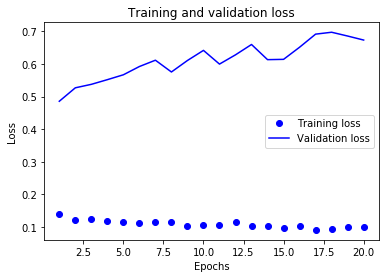

In [ ]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Next graph shows the change of accuracies, validation accuracy is fluctuating and recored the highest maximum when epoch is 2.

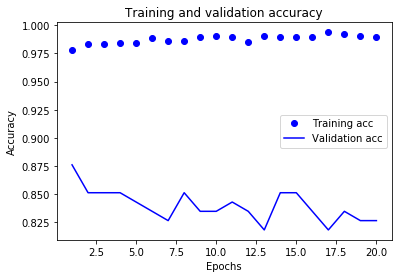

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###5.CNN

In [ ]:
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout

In [ ]:
embedding_size = 32

In [ ]:
cnn = Sequential()
cnn.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='Embedding_layer'))

cnn.add(Conv1D(filters=32, 
               kernel_size=7, 
               activation='relu',
               name='Conv_Layer'))

cnn.add(GlobalMaxPooling1D(name='Pooling_Layer'))

cnn.add(Dense(units=100,
              activation='relu',
              name='Dense_Layer'))

cnn.add(Dense(units=1,
              activation='sigmoid',
              name='Dense_Output_Layer'))

cnn.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#### Training

In [ ]:
cnn.fit(x_train_pad, y_train, batch_size = 16,
          validation_split=0.02, epochs= 2, class_weight = class_weights)
cnn.evaluate(x_train_pad, y_train)
preds_cnn_train = cnn.predict_classes(x_train_pad)
print(classification_report(y_train, preds_cnn_train, digits=3))

Train on 2365 samples, validate on 49 samples
Epoch 1/2
2365/2365 [==============================] - 3s 1ms/step - loss: 0.6868 - acc: 0.6960 - val_loss: 0.8012 - val_acc: 0.6735
Epoch 2/2
2414/2414 [==============================] - 0s 49us/step
              precision    recall  f1-score   support

           0      0.990     0.896     0.941      2064
           1      0.607     0.949     0.740       350

    accuracy                          0.903      2414
   macro avg      0.799     0.922     0.840      2414
weighted avg      0.935     0.903     0.912      2414



#### Testing

In [ ]:
cnn.evaluate(x_test_pad, y_test)
cnn_preds = cnn.predict_classes(x_test_pad)
print(classification_report(y_test, cnn_preds, digits=3))

603/603 [==============================] - 0s 74us/step
              precision    recall  f1-score   support

           0      0.886     0.802     0.842       506
           1      0.310     0.464     0.372        97

    accuracy                          0.748       603
   macro avg      0.598     0.633     0.607       603
weighted avg      0.794     0.748     0.767       603



In [ ]:
cnn_mod_fit = cnn.fit(x_train_pad, y_train, batch_size=16,
          validation_split=0.05, epochs=20)

Train on 2293 samples, validate on 121 samples
Epoch 1/20
2293/2293 [==============================] - 1s 378us/step - loss: 0.0065 - acc: 0.9991 - val_loss: 1.0271 - val_acc: 0.8264
Epoch 2/20
2293/2293 [==============================] - 1s 368us/step - loss: 0.0042 - acc: 0.9991 - val_loss: 1.0054 - val_acc: 0.7851
Epoch 3/20
2293/2293 [==============================] - 1s 365us/step - loss: 0.0023 - acc: 0.9996 - val_loss: 1.1231 - val_acc: 0.8017
Epoch 4/20
2293/2293 [==============================] - 1s 373us/step - loss: 0.0055 - acc: 0.9991 - val_loss: 1.1492 - val_acc: 0.8017
Epoch 5/20
2293/2293 [==============================] - 1s 374us/step - loss: 0.0043 - acc: 0.9996 - val_loss: 1.0544 - val_acc: 0.8099
Epoch 6/20
2293/2293 [==============================] - 1s 357us/step - loss: 0.0057 - acc: 0.9991 - val_loss: 1.0237 - val_acc: 0.8099
Epoch 7/20
2293/2293 [==============================] - 1s 370us/step - loss: 0.0049 - acc: 0.9991 - val_loss: 1.0158 - val_acc: 0.8099
E

In [ ]:
history_dict = cnn_mod_fit.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

#### Testing

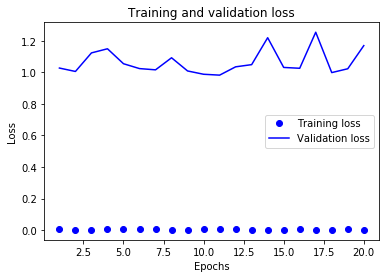

In [ ]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

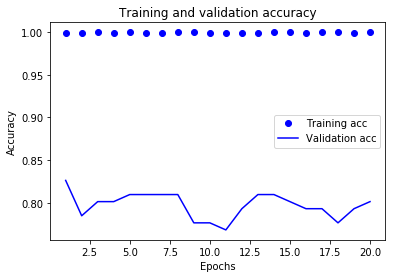

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()